# Demo of Ch6. Dimension Reduction
----
This is the sample code of TU-ETP-AD1062 Machine Learning Fundamentals.

For more information, please refer to:
https://sites.google.com/view/tu-ad1062-mlfundamentals/

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import sklearn.metrics
import sklearn.decomposition
import sklearn.discriminant_analysis
import sklearn.manifold
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mlfund.plot import Plot2D
from mlfund.plot import Plot3D

%matplotlib inline

## Demo 1. PCA on MNIST - Part 1.
----
The demo here conduct Principal Component Analysis on MNIST dataset, with data of class 6 only
1. Load the MNIST data with `target==6` first
2. Conduct dimension reduction with only 40 base preserved
3. Show all eigenvectors and its corresponded eigenvalue trends
4. Show the reconstruction results by the eigenvectors

Total data of class 6: 6876


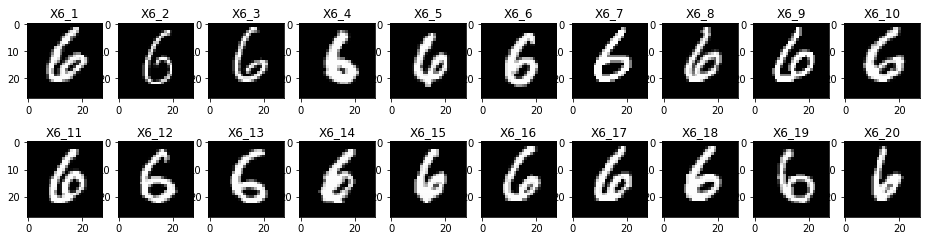

In [2]:
mnist = sklearn.datasets.fetch_mldata('MNIST original')

X6 = mnist.data[mnist.target == 6]
print("Total data of class 6: %d" % len(X6))

plt.figure(figsize=(16, 4))
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X6[i, :].reshape((28,28)), cmap='gray')
    
    plt.title("X6_%d" % (i + 1))

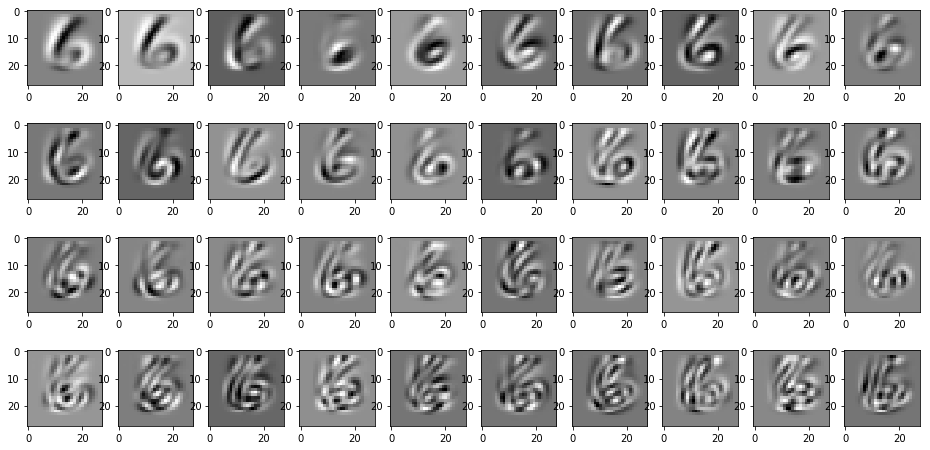

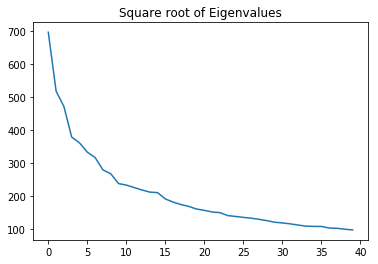

In [3]:
n_components=40

pca = sklearn.decomposition.PCA(n_components=n_components)
pca.fit( X6 )
X6_pca = pca.transform( X6 )

plt.figure(figsize=(16, 8))
for i in range(0, n_components):
    plt.subplot(n_components/10, 10, i+1)
    plt.imshow(pca.components_[i, :].reshape((28,28)), cmap='gray')

plt.figure()
plt.plot(np.sqrt(pca.explained_variance_))
plt.title('Square root of Eigenvalues')

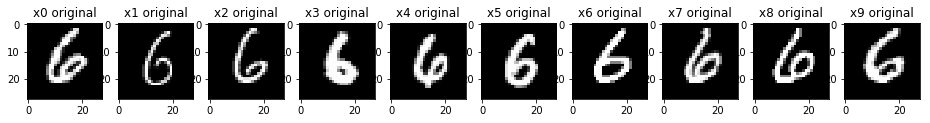

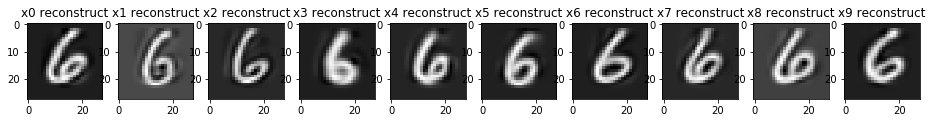

In [4]:
X6_recon = pca.inverse_transform(X6_pca)

plt.figure(figsize=(16, 4))
for i in range(0, 10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X6[i, :].reshape((28,28)), cmap='gray')
    plt.title('x%d original' % i)
    
plt.figure(figsize=(16, 4))
for i in range(0, 10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X6_recon[i, :].reshape((28,28)), cmap='gray')
    plt.title('x%d reconstruct' % i)


## Demo 2. PCA on MNIST - Part 2.
----
The demo here conduct Principal Component Analysis on MNIST dataset, with partial (5%) data considered
1. Load the MNIST first, with only 5% (`p=[0.95, 0.05]`) data selected for visualization purposes
2. Conduct dimension reduction with only 40 base preserved
3. Plot the scatter of the selected data

D:\Project\TU_ETP_MachineLearningFundamentals\github-tu-etp-ad1062\mlfund\plot.py:66: UserWarning: Dimension of samples exceeds 3, only plot the first-3 dimension
  warnings.warn("Dimension of samples exceeds 3, only plot the first-3 dimension")


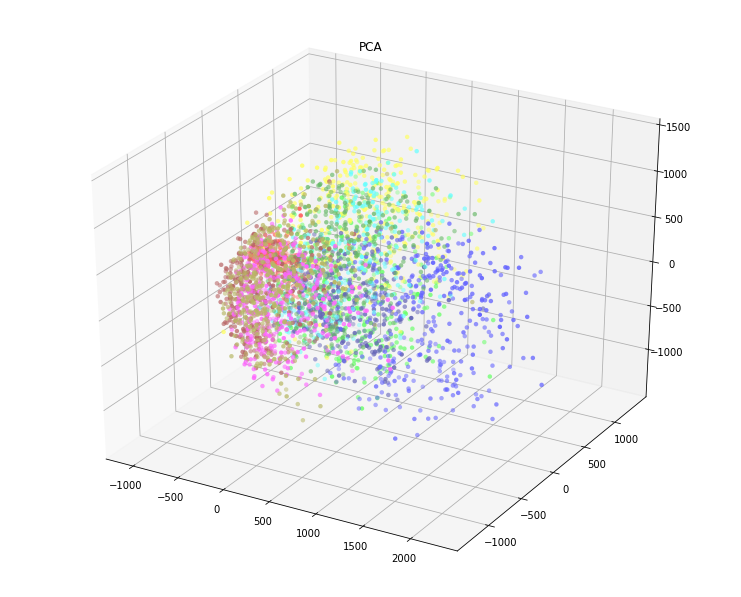

In [5]:
n_components=40

X = mnist.data
y = mnist.target
idx = np.random.choice(a=[False, True], size=len(X), p=[0.95, 0.05])
X = X[idx, :]
y = y[idx]

pca = sklearn.decomposition.PCA(n_components=n_components)
pca.fit( X )
X_pca = pca.transform( X )

plot = Plot3D()
plot.scatter(X_pca, y)
plot.title('PCA')
plot.show()

## Demo 3. LDA on MNIST
----
The demo here conducts Linear Discriminant Analysis on MNIST dataset, with partial (5%) data considered

C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Project\TU_ETP_MachineLearningFundamentals\github-tu-etp-ad1062\mlfund\plot.py:66: UserWarning: Dimension of samples exceeds 3, only plot the first-3 dimension
  warnings.warn("Dimension of samples exceeds 3, only plot the first-3 dimension")


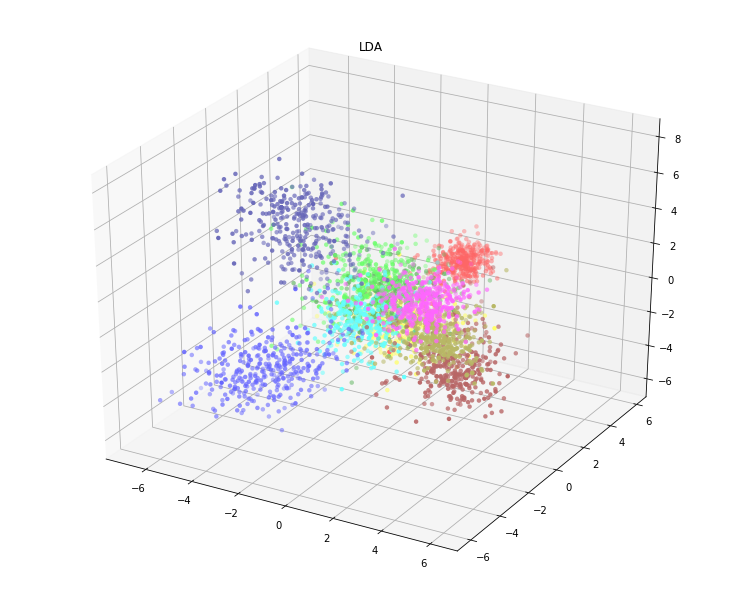

In [6]:
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(X, y)

X_lda = lda.transform(X)

plot = Plot3D()
plot.scatter(X_lda, y)
plot.title('LDA')
plot.show()

## Demo 4. t-SNE on MNIST
----
The demo here conducts t-distributed Stochastic Neighboring Embedding (t-SNE) on MNIST dataset, with partial (5%) data considered.

Notice that for the performance concern, the t-SNE requires conducting PCA on original data first.

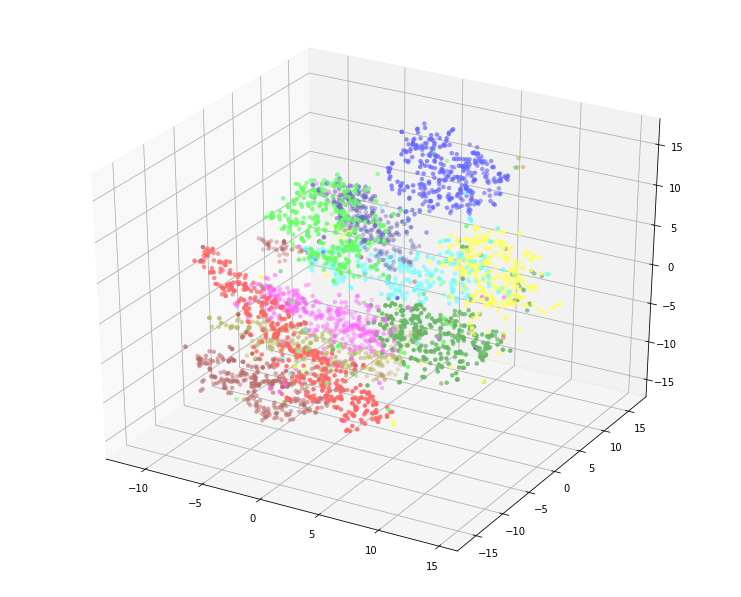

In [7]:
tSNE = sklearn.manifold.TSNE(n_components=3)
X_tSNE = tSNE.fit_transform(X_pca) 

plot = Plot3D()
plot.scatter(X_tSNE, y)
plot.show()